<a href="https://colab.research.google.com/github/filmerxyz/Standford_Sac_Dog/blob/master/Standford_Sac_Dog_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Split Folders

In [1]:
!pip install split-folders

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import shutil
import os
from os.path import join

import split_folders

from standoford_sac_dog_utils import *

# Hyperparameters

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 32

LR = 3e-5

EPOCHS = 100

# Data

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/Standford_Sac_Dog_dataset

Cloning into 'Standford_Sac_Dog_dataset'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1828 (delta 4), reused 14 (delta 2), pack-reused 1812
Receiving objects: 100% (1828/1828), 70.53 MiB | 43.48 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [5]:
mkdir_dir('/content/data_folder')

Directory  /content/data_folder  Created 


## Split

In [6]:
split_folders.ratio('/content/Standford_Sac_Dog_dataset/images', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.60, 0.20, 0.20))

Copying files: 1797 files [00:00, 5264.49 files/s]


In [7]:
train_path = '/content/data_folder/train'
val_path = '/content/data_folder/val'
test_path = '/content/data_folder/test'

In [8]:
train_gen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=0,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               horizontal_flip=True,
                               vertical_flip=True,)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_datagen = train_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

val_datagen = val_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=val_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

test_datagen = test_gen.flow_from_directory(batch_size=1,
                                          directory=test_path,
                                          shuffle=False,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode=None)

Found 1076 images belonging to 10 classes.
Found 355 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


# Model

In [11]:
def build_model():
    base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='prediction')(average_pooling_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    
    return model

In [12]:
model = build_model()

19996672/19993432 [==============================] - 0s 0us/step


In [13]:
model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
model_checkpoint = ModelCheckpoint(filepath='/content/standford_sac_dog_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [15]:
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint],
                    verbose=1)

Epoch 1/100
34/34 [==============================] - 24s 703ms/step - loss: 2.2280 - accuracy: 0.2258 - val_loss: 1.6297 - val_accuracy: 0.5746
Epoch 2/100
34/34 [==============================] - 21s 612ms/step - loss: 1.6269 - accuracy: 0.5567 - val_loss: 1.0522 - val_accuracy: 0.8592
Epoch 3/100
34/34 [==============================] - 21s 615ms/step - loss: 1.1759 - accuracy: 0.7147 - val_loss: 0.6604 - val_accuracy: 0.9324
Epoch 4/100
34/34 [==============================] - 21s 615ms/step - loss: 0.8331 - accuracy: 0.8113 - val_loss: 0.4459 - val_accuracy: 0.9549
Epoch 5/100
34/34 [==============================] - 21s 612ms/step - loss: 0.6677 - accuracy: 0.8392 - val_loss: 0.3236 - val_accuracy: 0.9690
Epoch 6/100
34/34 [==============================] - 21s 611ms/step - loss: 0.5270 - accuracy: 0.8652 - val_loss: 0.2744 - val_accuracy: 0.9690
Epoch 7/100
34/34 [==============================] - 21s 616ms/step - loss: 0.4522 - accuracy: 0.8820 - val_loss: 0.2430 - val_accuracy:

# Graph

## Accuracy

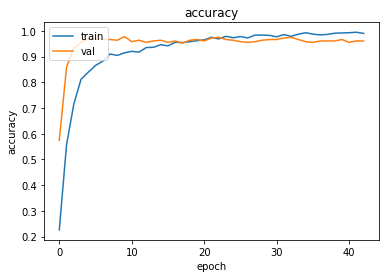

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

# Loss

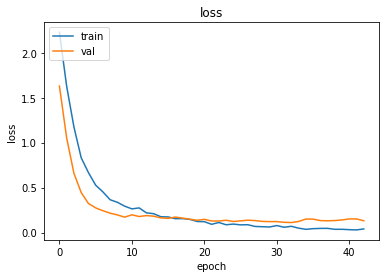

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [18]:
test_model = tf.keras.models.load_model('/content/standford_sac_dog_model.h5')

In [19]:
test_labels = test_datagen.classes
predictions = test_model.predict(test_datagen, steps=test_datagen.samples, verbose=1)

366/366 [==============================] - 7s 19ms/step


# Confusion Matrix

In [20]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['beagle', 'chihuahua', 'french_bulldog', 'golden_retriever', 'pomeranian', 'pug', 'rottweiler', 'shih-tzu', 'siberian_husky', 'yorkshire_terrier']

Confusion matrix, without normalization
[[38  0  0  0  0  0  0  0  1  0]
 [ 0 29  1  0  0  1  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  1  0]
 [ 1  0  0  0 43  0  0  0  0  1]
 [ 0  0  0  0  0 40  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 43  0  1]
 [ 0  0  0  1  0  2  0  0 36  0]
 [ 0  0  0  0  0  0  0  0  0 34]]


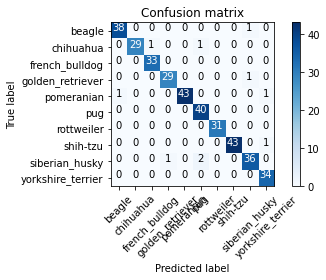

In [21]:
plot_confusion_matrix(cm, cm_plot_labels)

Normalized confusion matrix
[[0.97435897 0.         0.         0.         0.         0.
  0.         0.         0.02564103 0.        ]
 [0.         0.93548387 0.03225806 0.         0.         0.03225806
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96666667 0.         0.
  0.         0.         0.03333333 0.        ]
 [0.02222222 0.         0.         0.         0.95555556 0.
  0.         0.         0.         0.02222222]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.97727273 0.         0.02272727]
 [0.         0.         0.         0.02564103 0.         0.05128205
  0.         0.         0.92307692 0.   

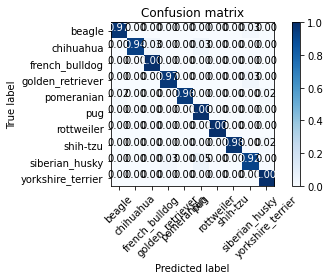

In [22]:
plot_confusion_matrix(cm, cm_plot_labels, True)

In [23]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=cm_plot_labels))

Confusion Matrix
[[38  0  0  0  0  0  0  0  1  0]
 [ 0 29  1  0  0  1  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  1  0]
 [ 1  0  0  0 43  0  0  0  0  1]
 [ 0  0  0  0  0 40  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 43  0  1]
 [ 0  0  0  1  0  2  0  0 36  0]
 [ 0  0  0  0  0  0  0  0  0 34]]
Classification Report
                   precision    recall  f1-score   support

           beagle       0.97      0.97      0.97        39
        chihuahua       1.00      0.94      0.97        31
   french_bulldog       0.97      1.00      0.99        33
 golden_retriever       0.97      0.97      0.97        30
       pomeranian       1.00      0.96      0.98        45
              pug       0.93      1.00      0.96        40
       rottweiler       1.00      1.00      1.00        31
         shih-tzu       1.00      0.98      0.99        44
   siberian_husky       0.95      0.92      0.94        39
yorkshire_terrier       0.94      1.00 